### DIDしてみる

In [1]:
# (1) tidyverseとbroomの読み込み
library("tidyverse")
library("broom")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# (2) John Snowデータの読み込み
## Data from Table.12 in Snow(1855)
## http://www.ph.ucla.edu/epi/snow/table12a.html

## 1849年におけるエリア毎のコレラによる死者数
### Southwark and Vauxhall Company
sv1849 <- c(283,157,192,249,259,226,352,97,111,8,235,92)

### Lambeth Company & Southwark and Vauxhall Company
lsv1849 <- c(256,267,312,257,318,446,143,193,243,215,544,187,153,81,113,176)

## 1849年におけるエリア毎のコレラによる死者数
### Southwark and Vauxhall Company
sv1854 <- c(371, 161, 148, 362, 244, 237, 282, 59, 171, 9, 240, 174)

### Lambeth Company & Southwark and Vauxhall Company
lsv1854 <- c(113,174,270,93,210,388,92,58,117,49,193,303,142,48,165,132)

## コレラの死者数を会社ごとにまとめる
sv_death <- c(sv1849, sv1854)
lsv_death <- c(lsv1849, lsv1854)

## どのデータがどのエリアのものか
sv_area <- paste0("sv_",c(1:length(sv1849), 1:length(sv1854)))
lsv_area <- paste0("lsv_", c(1:length(lsv1849), 1:length(lsv1854)))

## どのデータがどの年のものか
sv_year <- c(rep("1849",length(sv1849)), rep("1854", length(sv1854)))
lsv_year <- c(rep("1849",length(lsv1849)), rep("1854", length(lsv1854)))

## Southwark & Vauxhallのデータフレームを作成
sv <- data.frame(area = sv_area,
                 year = sv_year,
                 death = sv_death,
                 LSV = "0",
                 company = "Southwark and Vauxhall")

## Lambeth & Southwark and Vauxhallのデータフレームを作成
lsv <- data.frame(area = lsv_area,
                  year = lsv_year,
                  death = lsv_death,
                  LSV = "1",
                  company = "Lambeth & Southwark and Vauxhall")

## 地域・年別のデータセットの作成
JS_df <- rbind(sv, lsv) %>%
  mutate(LSV =
           if_else(company == "Lambeth & Southwark and Vauxhall", 1, 0))

## 会社別のデータセットを作成
JS_sum <- JS_df %>%
  group_by(company, LSV, year) %>%
  summarise(death = sum(death))

`summarise()` has grouped output by 'company', 'LSV'. You can override using the `.groups` argument.



In [3]:
JS_sum #今回使うデータ

company,LSV,year,death
<chr>,<dbl>,<chr>,<dbl>
Lambeth & Southwark and Vauxhall,1,1849,3904
Lambeth & Southwark and Vauxhall,1,1854,2547
Southwark and Vauxhall,0,1849,2261
Southwark and Vauxhall,0,1854,2458


In [4]:
# (3) 集計と可視化による分析
## 集計による推定
JS_grp_summary <- JS_sum %>%
  mutate(year = paste("year", year, sep = "_")) %>%
  spread(year, death) %>%
  mutate(gap = year_1854 - year_1849,
         gap_rate = year_1854/year_1849 - 1)
JS_grp_summary

company,LSV,year_1849,year_1854,gap,gap_rate
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lambeth & Southwark and Vauxhall,1,3904,2547,-1357,-0.34759221
Southwark and Vauxhall,0,2261,2458,197,0.08712959


`gap`のgapを取ると、-1554となり、Lambeth & Southwark and Vauxhallの水源の改善により1544人感染者が減ったことがわかる。

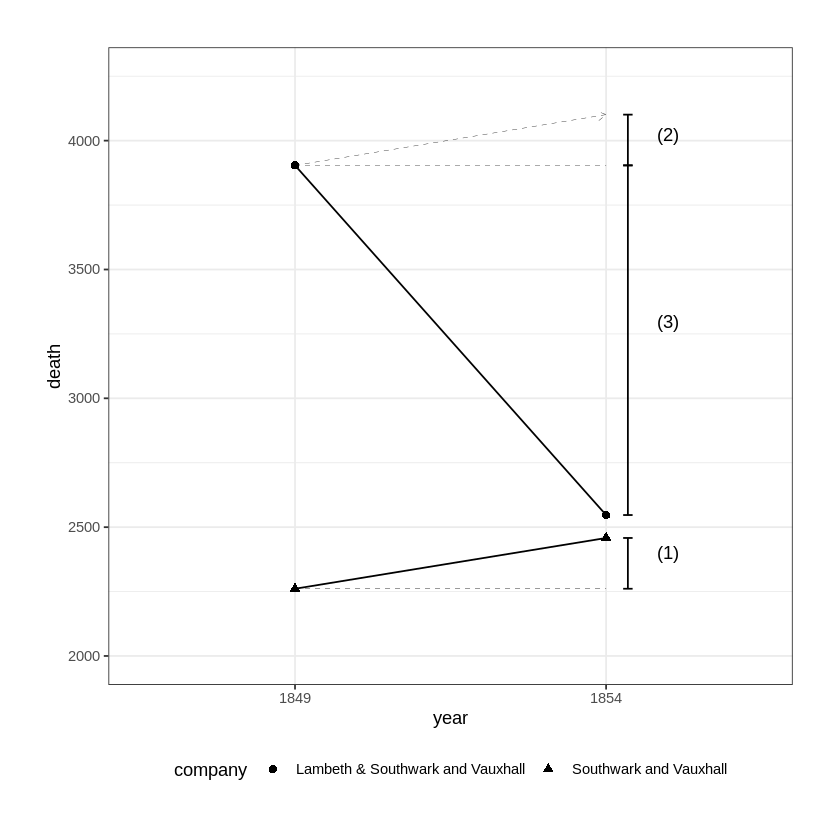

In [5]:
## ggplotによる可視化
did_plot <- JS_sum %>%
  ggplot(aes(y = death, x = year, shape = company)) +
  geom_point(size = 2) +
  geom_line(aes(group = company), linetype = 1) +
  ylim(2000, 4250) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "bottom",
        plot.margin = margin(1,1,1,1, "cm"))

## ggplotによる可視化(アノテーションを追加)
did_plot +
  annotate("text", x = 2.2, y = 2400, label = "(1)") +
  annotate("text", x = 2.2, y = 3904 + 197*0.6, label = "(2)") +
  annotate("text", x = 2.2, y = 3300, label = "(3)") +
  annotate("segment", # for common trend in treatment group
           x = 1, xend = 2,
           y = 3904, yend = 3904 + 197,
           arrow = arrow(length = unit(.2,"cm")),
           size = 0.1,
           linetype = 2) +
  annotate("segment", # for parallel trend
           x = 1, xend = 2,
           y = 2261, yend = 2261,
           size = 0.1,
           linetype = 2) +
  annotate("segment", # for parallel trend
           x = 1, xend = 2,
           y = 3904, yend = 3904,
           size = 0.1,
           linetype = 2) +
  annotate("segment", # for (1)
           x = 2.07, xend = 2.07,
           y = 2261, yend = 2458,
           arrow = arrow(ends = "both",
                         length = unit(.1,"cm"),angle = 90)) +
  annotate("segment", # for (2)
           x = 2.07, xend = 2.07,
           y = 3904, yend = 3904 + 197,
           arrow = arrow(ends = "both",
                         length = unit(.1,"cm"),angle = 90)) +
  annotate("segment", # for (3)
           x = 2.07, xend = 2.07,
           y = 3904, yend = 2547,
           arrow = arrow(ends = "both",
                         length = unit(.1,"cm"),angle = 90))

In [6]:
## 集計による推定(log)
JS_grp_summary_ln <- JS_sum %>%
  mutate(year = paste("year", year, sep = "_"),
         death = log(death)) %>%
  spread(year, death) %>%
  mutate(gap = year_1854 - year_1849)
JS_grp_summary_ln
# 背景にある再生産数的なものを抽出したいのかな？
# logを取ったあとの差分だから比率的なものが計算されるのか

company,LSV,year_1849,year_1854,gap
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Lambeth & Southwark and Vauxhall,1,8.269757,7.842671,-0.42708547
Southwark and Vauxhall,0,7.723562,7.807103,0.08354082


回帰分析を応用してDIDを行う

In [7]:
JS_sum %>%
  mutate(D1854 = if_else(year == 1854, 1, 0))
# この4サンプルを回帰することでdidみたいなことを行うことができる

company,LSV,year,death,D1854
<chr>,<dbl>,<chr>,<dbl>,<dbl>
Lambeth & Southwark and Vauxhall,1,1849,3904,0
Lambeth & Southwark and Vauxhall,1,1854,2547,1
Southwark and Vauxhall,0,1849,2261,0
Southwark and Vauxhall,0,1854,2458,1


$$death =  \beta_0 + \beta_1 LSV +  \beta_2 D1854 +  \beta_3 D1854 * LSV$$
で4サンプルを表現できる。

* $\beta_0$にはすべてが0の場合、つまりSouthwark and Vauxhall社かつ、1849年のときの感染者数が現れる。
* $\beta_1$には、1849年における、Lambeth & Southwark and Vauxhall社とSouthwark and Vauxhall社の差が現れる。
* $\beta_2$には、Southwark and Vauxhall社における、1845→1854年の感染者数の変化が現れる。
* $\beta_3$には、DIDによってもとめた、Lambeth & Southwark and Vauxhall社の感染者数の減り方(？)と同じ物が出てくる

3次元に平行四辺形を張るイメージ

In [8]:
# (4) 回帰分析を用いたDID
## Difference in Difference
JS_did <- JS_sum %>%
  mutate(D1854 = if_else(year == 1854, 1, 0)) %>%
  lm(data = ., death ~ LSV + D1854 + D1854:LSV) %>%
  tidy()
JS_did
# これでDIDを行えるのは楽！

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2261,NaN,NaN,NaN
LSV,1643,NaN,NaN,NaN
D1854,197,NaN,NaN,NaN
LSV:D1854,-1554,NaN,NaN,NaN


In [9]:
## 時間による効果は比率として表したほうが妥当であるという議論があったので、目的変数に対数をとって比率の場合の効果量を求める
## Difference in Difference(log)
JS_did_log <- JS_sum %>%
  mutate(D1854 = if_else(year == 1854, 1, 0)) %>%
  lm(data = ., log(death) ~ LSV + D1854 + D1854:LSV) %>%
  tidy()
JS_did_log

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),7.72356247,NaN,NaN,NaN
LSV,0.54619448,NaN,NaN,NaN
D1854,0.08354082,NaN,NaN,NaN
LSV:D1854,-0.51062629,NaN,NaN,NaN


In [10]:
# エリアも説明変数に加えてみよう
## Difference in Difference(エリア単位)
JS_did_area <- JS_df %>%
  mutate(D1854 = if_else(year == 1854, 1, 0)) %>%
  lm(data = ., death ~ LSV + area + D1854 + D1854:LSV) %>%
  tidy() %>%
  filter(!str_detect(term, "area"))

## Difference in Difference(州単位、log)
JS_did_area_log <- JS_df %>%
  mutate(D1854 = if_else(year == 1854, 1, 0)) %>%
  lm(data = ., log(death) ~ LSV + area + D1854 + D1854:LSV) %>%
  tidy() %>%
  filter(!str_detect(term, "area"))

JS_did_area #各エリアで平均して100人程度感染者数が減っている となった (地域を集約していたのバイアスが除かれたイメージ)

JS_did_area_log # 率としては半分ぐらい.すごい！

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),132.79167,45.72692,2.9040148,0.007420253
LSV,94.11458,64.35598,1.4624061,0.155613541
D1854,16.41667,25.36473,0.6472241,0.523160787
LSV:D1854,-101.22917,33.55439,-3.0168681,0.005649081


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.88863746,0.2398049,20.3858917,1.629158e-17
LSV,0.49373658,0.3375010,1.4629189,1.554742e-01
D1854,0.07391884,0.1330198,0.5556979,5.831681e-01
LSV:D1854,-0.56610166,0.1759687,-3.2170585,3.453469e-03


DIDにおける標準偏差とかの話は難しくてよくわからなかった

### 大規模禁煙キャンペーンがもたらすタバコの売上への影響

In [11]:
# (6) ライブラリの読み込み
library("Ecdat")

# (7) Proposition99の分析：集計による分析
## データの準備

### Common Trend Assumptionの為に分析から特定の州を外す
### タバコの税金が1988年以降50セント以上上がった州のリスト
### Alaska, Hawaii, Maryland, Michigan, New Jersey, New York, Washington
skip_state <- c(3,9,10,22,21,23,31,33,48)

### Cigarデータセットの読み込み
### skip_stateに含まれる州のデータを削除
Cigar <- Cigar %>%
  filter(!state %in% skip_state,
         year >= 70) %>%
  mutate(area = if_else(state == 5, "CA", "Rest of US"))

Cigar

Loading required package: Ecfun


Attaching package: ‘Ecfun’


The following object is masked from ‘package:base’:

    sign



Attaching package: ‘Ecdat’


The following object is masked from ‘package:datasets’:

    Orange




,state,year,price,pop,pop16,cpi,ndi,sales,pimin,area
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
8,1,70,39.6,3444.0,2394.6,38.8,2591.039,89.8,34.3,Rest of US
9,1,71,42.7,3481.0,2443.5,40.5,2785.316,95.4,35.8,Rest of US
10,1,72,42.3,3511.0,2484.7,41.8,3034.808,101.1,37.4,Rest of US
11,1,73,42.1,3540.0,2526.0,44.4,3387.574,102.9,37.3,Rest of US
12,1,74,43.1,3574.0,2573.9,49.3,3718.867,108.2,41.4,Rest of US
13,1,75,46.6,3614.0,2623.7,53.8,4087.993,111.7,43.0,Rest of US
14,1,76,50.4,3657.0,2677.4,56.9,4486.772,116.2,46.4,Rest of US
15,1,77,50.1,3690.0,2719.6,60.6,4899.866,117.1,48.8,Rest of US
16,1,78,55.1,3728.0,2764.6,65.2,5450.998,123.0,53.6,Rest of US


In [12]:
## 前後比較による分析
Cigar %>%
  mutate(period = if_else(year > 87, "after", "before"),
         state = if_else(state == 5, "CA", "Rest of US")) %>%
  group_by(period, state) %>%
  summarise(sales = sum(sales*pop16)/sum(pop16)) %>%
  spread(state, sales)

`summarise()` has grouped output by 'period'. You can override using the `.groups` argument.



period,CA,Rest of US
<chr>,<dbl>,<dbl>
after,77.1250,106.8877
before,116.6576,126.8421


Rest of USでは20箱の減少傾向なので、並行トレンド仮定をするとCAでは25箱程度の売上の減少が生じた

`summarise()` has grouped output by 'period'. You can override using the `.groups` argument.



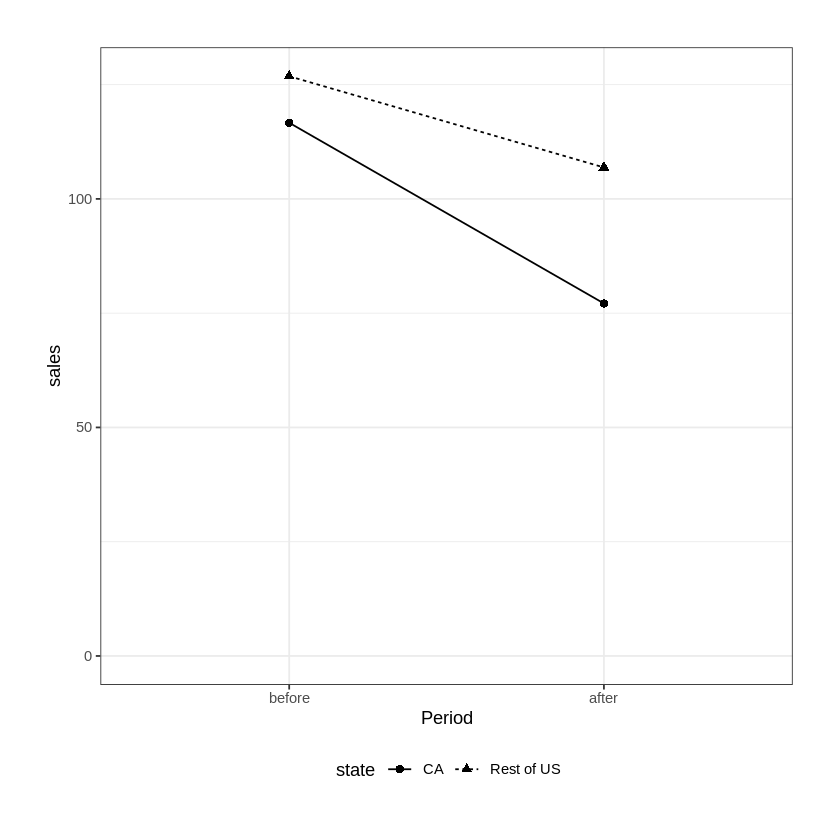

In [13]:
## 前後比較のプロット
Cigar %>%
  mutate(period = if_else(year > 87, "after", "before"),
         state = if_else(state == 5, "CA", "Rest of US")) %>%
  group_by(period, state) %>%
  summarise(sales = sum(sales*pop16)/sum(pop16)) %>%
  ggplot(aes(y = sales,
             x = period,
             shape = state,
             linetype = state)) +
  geom_point(size = 2) +
  geom_line(aes(group = state)) +
  ylim(0, NA) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "bottom",
        plot.margin = margin(1,1,1,1, "cm")) +
  scale_x_discrete(name ="Period",limits=c("before","after"))

回帰分析で、各年における平均的な効果量 や 各州における平均的な効果量 を見てみる

In [14]:
# (8) DIDのためのデータを準備
## カリフォルニア州とその他という2グループのデータ
Cigar_did_sum <- Cigar %>%
  mutate(post = if_else(year > 87, 1, 0),
         ca = if_else(state == 5, 1, 0),
         state = factor(state),
         year_dummy = paste("D", year, sep = "_")) %>%
  group_by(post, year, year_dummy, ca) %>%
  summarise(sales = sum(sales*pop16)/sum(pop16))

## カリフォルニア州とその他の州という州ごとでのデータ
Cigar_did_data <- Cigar %>%
  mutate(post = if_else(year > 87, 1, 0),
         ca = if_else(state == 5, 1, 0),
         state = factor(state),
         year_dummy = paste("D", year, sep = "_")) %>%
  group_by(post, ca, year, year_dummy, state) %>%
  summarise(sales = sum(sales*pop16)/sum(pop16))
Cigar_did_sum |> head()
Cigar_did_data |> head()

`summarise()` has grouped output by 'post', 'year', 'year_dummy'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'post', 'ca', 'year', 'year_dummy'. You can override using the `.groups` argument.



post,year,year_dummy,ca,sales
<dbl>,<int>,<chr>,<dbl>,<dbl>
0,70,D_70,0,115.0333
0,70,D_70,1,123.0000
0,71,D_71,0,118.1176
0,71,D_71,1,121.0000
0,72,D_72,0,120.8572
0,72,D_72,1,123.5000


post,ca,year,year_dummy,state,sales
<dbl>,<dbl>,<int>,<chr>,<fct>,<dbl>
0,0,70,D_70,1,89.8
0,0,70,D_70,4,100.3
0,0,70,D_70,7,120.0
0,0,70,D_70,8,155.0
0,0,70,D_70,11,109.9
0,0,70,D_70,13,102.4


In [15]:
# (9) カリフォルニア州とその他というグループでの分析
## 2グループでのデータでの分析
Cigar_did_sum_reg <- Cigar_did_sum %>%
  lm(data = ., sales ~ ca + post + ca:post + year_dummy) %>%
  tidy() %>%
  filter(!str_detect(term, "state"),
         !str_detect(term, "year"))
Cigar_did_sum_reg

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),123.561534,4.519375,27.340401,6.686611e-18
ca,-9.089784,2.073632,-4.383510,2.597039e-04
post,-23.797791,6.606396,-3.602235,1.674671e-03
ca:post,-20.543519,4.447444,-4.619174,1.479716e-04


一人あたりタバコの売上を20箱程度減少させている

In [16]:
## 2グループでのデータでの分析(log)
Cigar_did_sum_logreg <- Cigar_did_sum %>%
  lm(data = ., log(sales) ~ ca + post + ca:post + year_dummy) %>%
  tidy() %>%
  filter(!str_detect(term, "state"),
         !str_detect(term, "year"))
Cigar_did_sum_logreg

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.81705754,0.04212091,114.362628,7.726809e-31
ca,-0.07670921,0.01932640,-3.969142,6.994158e-04
post,-0.23170193,0.06157209,-3.763100,1.143104e-03
ca:post,-0.25304451,0.04145050,-6.104739,4.665575e-06


効果料を割合だと解釈すると25%の減少効果！

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



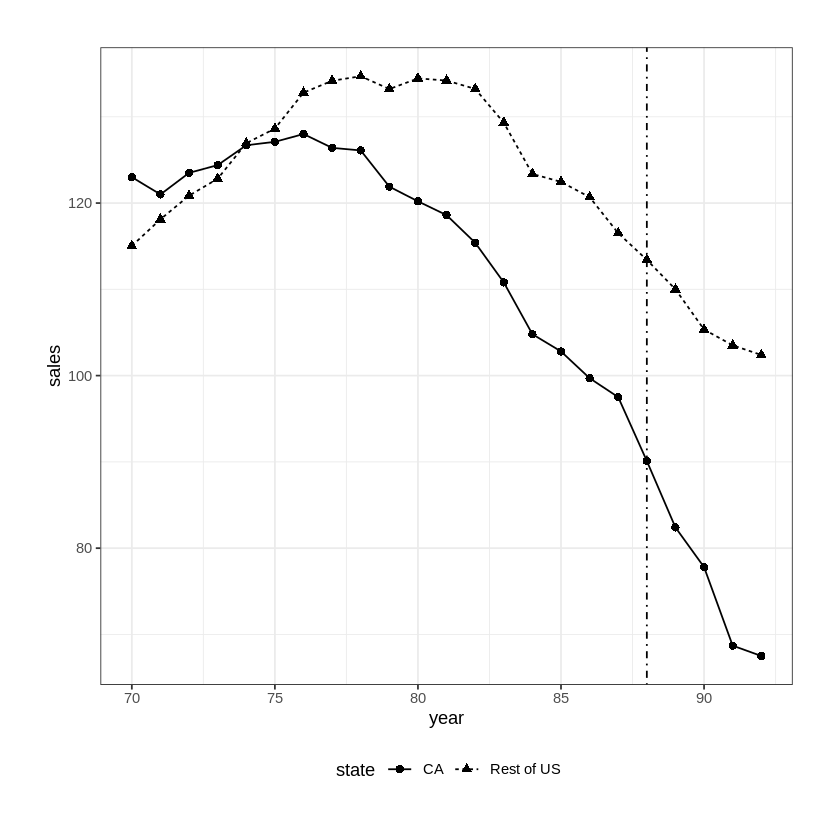

In [17]:
## タバコの売上のトレンドを示すプロット
Cigar %>%
  mutate(state = if_else(state == 5, "CA", "Rest of US")) %>%
  group_by(year,state) %>%
  summarise(sales = sum(sales*pop16)/sum(pop16)) %>%
  ggplot(aes(y = sales,
             x = year,
             shape = state,
             linetype = state)) +
  geom_line() +
  geom_point(size = 2) +
  geom_vline(xintercept = 88, linetype = 4) +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "bottom",
        plot.margin = margin(1,1,1,1, "cm"))

ただし、図より並行トレンド仮定は正しくなさそうである。88年までの振る舞いが並行的でない。とくに75年辺り

In [18]:
#おまけ
## 州ごとのデータでの分析
Cigar_did_data_cluster <- Cigar_did_data %>%
  miceadds::lm.cluster(data = .,
                       sales ~ ca + state + post + ca:post + year_dummy,
             cluster = "state") %>%
  summary()

## 結果の抽出
did_cluster_result <- Cigar_did_data_cluster[row.names(Cigar_did_data_cluster) == "ca:post",]
did_cluster_result


ERROR: Error in loadNamespace(x): there is no package called ‘miceadds’


### CausalImpactを試してみる

In [19]:
# (11) CausalImpactを利用した分析

## CigarデータをCausalImpact用に整形
### 目的変数としてカリフォルニア州の売上 だけ抜き出す
Y <- Cigar %>% filter(state == 5) %>% pull(sales)

### 共変量として他の州の売上を抜き出し整形
X_sales <- Cigar %>%
  filter(state != 5) %>% #カリフォルニアだけ除く
  select(state, sales, year) %>% # 州、売上、年を考慮
  spread(state,sales) # 横にstateを展開する。値はsales
X_sales |> head()

,year,1,4,7,8,11,13,14,15,16,⋯,41,42,43,44,45,46,47,49,50,51
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,70,89.8,100.3,120.0,155.0,109.9,102.4,124.8,134.6,108.5,⋯,103.6,92.7,99.8,106.4,65.5,122.6,124.3,114.5,106.4,132.2
2,71,95.4,104.1,117.6,161.1,115.7,108.5,125.6,139.3,108.4,⋯,115.0,96.7,106.3,108.9,67.7,124.4,128.4,111.5,105.4,131.7
3,72,101.1,103.9,110.8,156.3,117.0,126.1,126.6,149.2,109.4,⋯,118.7,103.0,111.5,108.6,71.3,138.0,137.0,117.5,108.8,140.0
4,73,102.9,108.0,109.3,154.7,119.8,121.8,124.4,156.0,110.6,⋯,125.5,103.5,109.7,110.4,72.7,146.8,143.1,116.6,109.5,141.2
5,74,108.2,109.7,112.4,151.3,123.7,125.6,131.9,159.6,116.1,⋯,129.7,108.4,114.8,114.7,75.6,151.8,149.6,119.9,111.8,145.8
6,75,111.7,114.8,110.2,147.6,122.9,123.3,131.8,162.4,120.5,⋯,130.5,113.5,117.4,116.0,75.8,155.5,152.7,123.2,113.5,160.7


In [20]:
### 介入が行われるデータを示す
pre_period <- c(1:NROW(X_sales))[X_sales$year < 88]
post_period <- c(1:NROW(X_sales))[X_sales$year >= 88]
### 目的変数と共変量をバインドする
CI_data <- cbind(Y,X_sales) %>% select(-year)
CI_data |> head()

,Y,1,4,7,8,11,13,14,15,16,⋯,41,42,43,44,45,46,47,49,50,51
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,123.0,89.8,100.3,120.0,155.0,109.9,102.4,124.8,134.6,108.5,⋯,103.6,92.7,99.8,106.4,65.5,122.6,124.3,114.5,106.4,132.2
2,121.0,95.4,104.1,117.6,161.1,115.7,108.5,125.6,139.3,108.4,⋯,115.0,96.7,106.3,108.9,67.7,124.4,128.4,111.5,105.4,131.7
3,123.5,101.1,103.9,110.8,156.3,117.0,126.1,126.6,149.2,109.4,⋯,118.7,103.0,111.5,108.6,71.3,138.0,137.0,117.5,108.8,140.0
4,124.4,102.9,108.0,109.3,154.7,119.8,121.8,124.4,156.0,110.6,⋯,125.5,103.5,109.7,110.4,72.7,146.8,143.1,116.6,109.5,141.2
5,126.7,108.2,109.7,112.4,151.3,123.7,125.6,131.9,159.6,116.1,⋯,129.7,108.4,114.8,114.7,75.6,151.8,149.6,119.9,111.8,145.8
6,127.1,111.7,114.8,110.2,147.6,122.9,123.3,131.8,162.4,120.5,⋯,130.5,113.5,117.4,116.0,75.8,155.5,152.7,123.2,113.5,160.7


In [21]:
## CausalImpactによる分析
impact <- CausalImpact::CausalImpact(CI_data,
                       pre.period = c(min(pre_period), max(pre_period)),
                       post.period = c(min(post_period), max(post_period)))
## 結果のplot
plot(impact)

ERROR: Error in loadNamespace(x): there is no package called ‘CausalImpact’


In [22]:
impact

ERROR: Error in eval(expr, envir, enclos): object 'impact' not found
